## Face Recognition

We can also combine multiple OpenDR tools to perform more complex tasks. In this tutorial, we will combine face detection and face recongition tools to perform face recognition using a web cam.

Let's import some tools:

In [1]:
import cv2
import numpy as np
from utils import VideoReader
from matplotlib import pyplot as plt
%matplotlib inline

Let's start by initializing the face recognition tool:

In [2]:
from opendr.perception.face_recognition import FaceRecognitionLearner

recognizer = FaceRecognitionLearner(device='cuda', backbone='mobilefacenet')
recognizer.download(path=".")
recognizer.load('opendr_face_backbone')

Model already exists
Loading backbone 'mobilefacenet'


Then we need to create a database of faces to recognize. This can be done very easily just by placing the face images into folders according to the subject to be recognized:

In [3]:
%ls persons

 nick/       'Person 2'/  'Person 4'/  'Person 6'/
'Person 1'/  'Person 3'/  'Person 5'/


In [4]:
%ls persons/Person\ 4

1.jpg  2.jpg


Let's check a person's image:

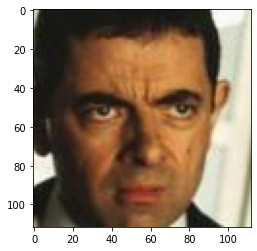

In [5]:
from os.path import join
image_path = join("persons", "Person 4", "2.jpg")
img = cv2.imread(image_path)
plt.imshow(img[:, :, [2, 1, 0]])

Check our saved image

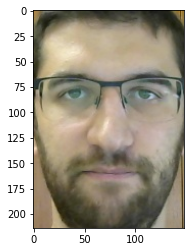

In [6]:
image_path = join("persons", "nick", "1.jpg")
img = cv2.imread(image_path)
plt.imshow(img[:, :, [2, 1, 0]])

After collecting our images we need to build the recognition database:

In [7]:
recognizer.fit_reference("persons", save_path="database.pkl")

We are now ready to perform face recognition. First, we will grab a frame from the camera, perform face detection and then perform face recognition. To this end, we first need to initialize the face recognizer:

In [8]:
from opendr.perception.object_detection_2d import RetinaFaceLearner
from opendr.perception.object_detection_2d.datasets.transforms import BoundingBoxListToNumpyArray
from opendr.perception.object_detection_2d.utils.vis_utils import draw_bounding_boxes

learner = RetinaFaceLearner(backbone='resnet', device='cuda')
learner.download(".", mode="pretrained")
learner.load("./retinaface_resnet")

We are now ready to build the inference loop as before:

In [9]:
image_provider = VideoReader(0)
for counter, img in enumerate(image_provider):

    boxes = learner.infer(img)
    bboxes = BoundingBoxListToNumpyArray()(boxes)[:, :4].astype(np.int)
    # If we have detected a face
    for bbox in bboxes:
        # Crop it
        
        face_img = img[bbox[1]:bbox[3],bbox[0]:bbox[2], :]

        # Recognize the cropped image
        results = recognizer.infer(face_img)

        # Plot the results
        if results.confidence is not None and results.confidence > 0.4:
            cv2.putText(img, results.description , (bbox[0], max(bbox[1]-10, 0)),  cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1)
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)            
        else:
            cv2.putText(img, "Not found", (bbox[0], max(bbox[1]-10, 0)),  cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1)
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2)
            
    cv2.imshow('Result', img)
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()
image_provider.close()

[18:26:18] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
/home/nick/opendr_internal/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nick/opendr_internal/venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
